In [12]:
import math
import numpy as np
import random as rand
from numba import jit,int64,float64
import matplotlib.pyplot as plt
%matplotlib inline

#To increase cell width:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#Color-blind friendly colors to plot:
CB_colors = ['#377eb8', '#ff7f00', '#4daf4a','#f781bf', '#a65628', '#984ea3','#999999', '#e41a1c', '#dede00']

#Running the script with parameter definitions and functions:
%run 0-n_populations_functions.py

K = 1; 0.5*dg/dt = 2500.0
D = 50.0; 0.5*dg**2/dt = 1000.0000000000001


<Figure size 432x288 with 0 Axes>

Text(0.5, 1.0, 'Sugar vs. time')

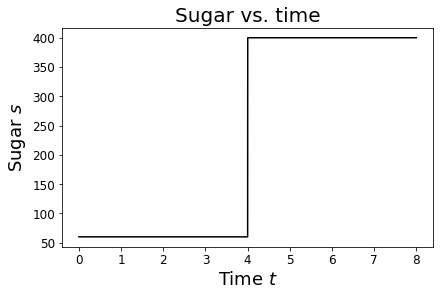

In [13]:
flag = False
sug_dyn = np.ones_like(TimeRange)
temp_sug = np.array([])
num_jumps = 2
for i in range(num_jumps):
    if (i%2==0):
        temp_sug = np.concatenate((temp_sug,60*np.array_split(sug_dyn,num_jumps)[i]))
    elif (i%2==1):
        temp_sug = np.concatenate((temp_sug,400*np.array_split(sug_dyn,num_jumps)[i]))
sug_dyn = temp_sug

fig,ax = plt.subplots(1,1,constrained_layout='true')

ax.plot(TimeRange,sug_dyn,c='k')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Time $t$',fontsize=18)
ax.set_ylabel('Sugar $s$',fontsize=18)
ax.set_title('Sugar vs. time', fontsize=20)
# fig.savefig("6_sug_vs_t.pdf",format="pdf",dpi=1200,bbox_inches="tight",pad_inches=0)

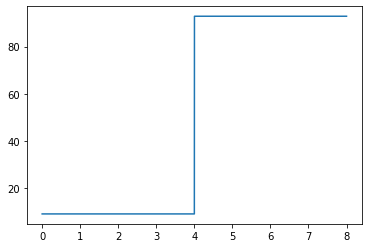

In [14]:
#Finding the g_opt as a function of time through sugar:
g_opt_dyn = np.zeros_like(sug_dyn)

G,S = np.meshgrid(g,sug_dyn)

fitness_2d = fitness(G,S,delta)
g_opt_dyn = g[np.argmax(fitness_2d,axis=1)]

plt.plot(TimeRange,g_opt_dyn)

In [15]:
#alpha and delta:
delta = 1
print(f"alpha = {alpha}; delta = {delta}")

alpha = 1; delta = 1


In [16]:
#The starting distributions:
g_reg = g[np.argmax(fitness(g,sug_dyn[0],delta))]
print(f"g_reg={round(g_reg,2)}")

#Generating the initial distributions:
g_peak = 0.5*(g_min+g_max)
#We don't want a standard deviation of 0, so even if the g_reg is 0, we set the s.d. of p0_reg to 1:
p0_unreg = Gaussian(g,g_peak,np.maximum(np.sqrt(alpha*g_peak),1))
p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
# p0_unreg = np.ones_like(g)
# p0_unreg = p0_unreg/np.trapz(p0_unreg,dx=dg)
p0_reg = Gaussian(g,g_reg,np.maximum(np.sqrt(alpha*g_reg),1))
p0_reg = p0_reg/np.trapz(p0_reg,dx=dg)

g_reg=9.2


In [17]:
dyn_p_unreg, dyn_p_reg, dyn_fit_unreg, dyn_norm_fit_unreg, dyn_fit_reg, dyn_norm_fit_reg = selection_dyn(p0_unreg,p0_reg,sug_dyn,alpha,delta)

In [18]:
np.max(np.trapz(dyn_p_reg,dx=dg,axis=1))

1.0000000000000016

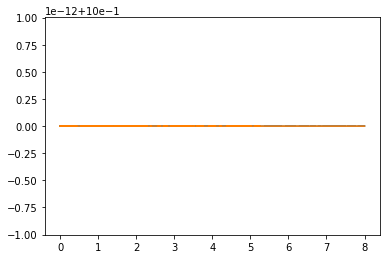

In [19]:
plt.plot(TimeRange,np.trapz(dyn_p_unreg,dx=dg,axis=1),c=CB_colors[0])
plt.plot(TimeRange,np.trapz(dyn_p_reg,dx=dg,axis=1),c=CB_colors[1])

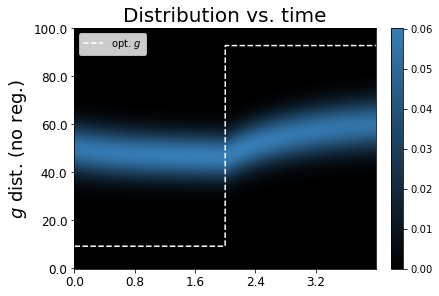

In [9]:
#plotting the distributions:
from matplotlib import cm 
from matplotlib.colors import ListedColormap,LinearSegmentedColormap

N = 256
no_reg = np.ones((N, 4))
no_reg[:, 0] = np.linspace(0, 55/256, N) # R = 55
no_reg[:, 1] = np.linspace(0, 126/256, N) # G = 126
no_reg[:, 2] = np.linspace(0, 184/256, N)  # B = 184
no_reg_cmp = ListedColormap(no_reg)

with_reg = np.ones((N, 4))
with_reg[:, 0] = np.linspace(0, 255/256, N) # R = 255
with_reg[:, 1] = np.linspace(0, 127/256, N) # G = 127
with_reg[:, 2] = np.linspace(0, 0/256, N)  # B = 0
with_reg_cmp = ListedColormap(with_reg)


fig,ax = plt.subplots(1,1,constrained_layout='true')
pic=ax.imshow(dyn_p_unreg.T,cmap=no_reg_cmp,origin='lower',aspect='auto')
cbar = plt.colorbar(pic,shrink=1.0)

xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(ticks = xticks[1:-1],labels=np.around(xticks[1:-1]*dt,2))
ax.set_yticks(ticks = yticks[1:-1],labels=np.around(yticks[1:-1]*dg,2))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.plot(g_opt_dyn/dg,'w--',label=r'opt. $g$')
# ax.set_xlabel(r'Time $t$',fontsize=18)
ax.set_ylabel(r'$g$ dist. (no reg.)',fontsize=18)
ax.set_title(r'Distribution vs. time',fontsize=20)
ax.legend(loc='best')
# fig.savefig("6_p_unreg_vs_t.pdf",format="pdf",dpi=400,bbox_inches="tight",pad_inches=0)

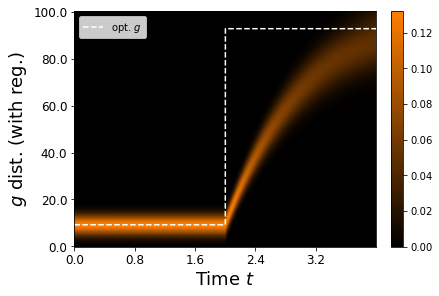

In [10]:
fig,ax = plt.subplots(1,1,constrained_layout='true')
pic=ax.imshow(dyn_p_reg.T,cmap=with_reg_cmp,origin='lower',aspect='auto')
cbar = plt.colorbar(pic,shrink=1.0)

xticks = ax.get_xticks()
yticks = ax.get_yticks()
ax.set_xticks(ticks = xticks[1:-1],labels=np.around(xticks[1:-1]*dt,2))
ax.set_yticks(ticks = yticks[1:-1],labels=np.around(yticks[1:-1]*dg,2))
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Time $t$',fontsize=18)
ax.set_ylabel(r'$g$ dist. (with reg.)',fontsize=18)
ax.plot(g_opt_dyn/dg,'w--',label=r'opt. $g$')
ax.legend(loc='best')
# fig.savefig("6_p_reg_vs_t.pdf",format="pdf",dpi=400,bbox_inches="tight",pad_inches=0)
# ax.set_title(r'Distribution vs. time',fontsize=20)

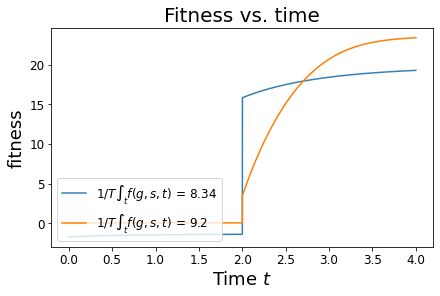

In [11]:
#T=4:
fig,ax = plt.subplots(1,1,constrained_layout='true')

ax.plot(TimeRange,dyn_fit_unreg,color=CB_colors[0],label=fr'$1/T \int_t f(g,s,t)$ = {np.around(np.trapz(dyn_fit_unreg,dx=dt)/T,2)}')
ax.plot(TimeRange,dyn_fit_reg,color=CB_colors[1],label=fr'$1/T \int_t f(g,s,t)$ = {np.around(np.trapz(dyn_fit_reg,dx=dt)/T,2)}')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.set_xlabel(r'Time $t$',fontsize=18)
ax.set_ylabel('fitness',fontsize=18)
ax.set_title('Fitness vs. time', fontsize=20)
ax.legend(loc='lower left', fontsize=12)
# fig.savefig("6_fit_vs_t.pdf",format="pdf",dpi=400,bbox_inches="tight",pad_inches=0)